In [1]:
library(devtools); install_github("emauryg/STRAND_R",ref="development");
library(MCMCpack); library(mvtnorm); library(NMF); library(clue); library(nnet); 

library(batch); library(Matrix); library(torch); library(tidyverse)

library(strandR)
library(torch)
library(tidyverse)

if (cuda_is_available()) {
   device <<- torch_device("cuda:0")
} else {
   device <<- torch_device("cpu")
}




Loading required package: usethis




Skipping 2 packages not available: Biobase, rtracklayer



✔  checking for file ‘/tmp/RtmpuW0Eyc/remotes29c046d078afb/emauryg-STRAND_R-ea8cc8e/DESCRIPTION’
─  preparing ‘strandR’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘strandR_0.0.1.tar.gz’
   


Installing package into ‘/home/eam63/R-3.6.1/library’
(as ‘lib’ is unspecified)

Loading required package: coda

Loading required package: MASS

##
## Markov Chain Monte Carlo Package (MCMCpack)

## Copyright (C) 2003-2021 Andrew D. Martin, Kevin M. Quinn, and Jong Hee Park

##
## Support provided by the U.S. National Science Foundation

## (Grants SES-0350646 and SES-0350613)
##

Loading required package: pkgmaker

Loading required package: registry

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 31/32

  To enable shared memory capabilities, try: install.extras('
NMF
')


Attaching package: ‘NMF’


The following object is masked from ‘package:coda’:

    niter


── Attaching packages ─────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.

In [2]:
system("export CUDA_LAUNCH_BLOCKING=1")
D=100
K=5
V=96
p=10


# device <- torch_device("cpu")

set.seed(778)
torch_manual_seed(778)

truth_vals <- generate_data(V,K,D,p)

count_matrix = truth_vals$count_matrix
xmat = truth_vals$X

In [3]:
init_pars <- NMFinit(count_matrix,xmat,K, max_iter=10000)

mod0 = runEM(init_pars, count_matrix, X=xmat, tau=1)

E-step:

E-step ELBO:  -1484.7325

E-step ELBO:  -1482.14328125

E-step ELBO:  -1480.708125

E-step ELBO:  -1479.85953125

E-step ELBO:  -1479.315

E-step ELBO:  -1478.6365625

E-step ELBO:  -1478.36734375

E-step ELBO:  -1478.4203125

M-step: 

----------------

Current EM ELBO: -1411.62609375

-----------------

E-step:

E-step ELBO:  -1411.8346875

E-step ELBO:  -1412.24453125

E-step ELBO:  -1412.01125

E-step ELBO:  -1412.085

M-step: 

----------------

Current EM ELBO: -1381.905625

-----------------

E-step:

E-step ELBO:  -1381.51140625

E-step ELBO:  -1381.57546875

M-step: 

----------------

Current EM ELBO: -1367.70796875

-----------------

E-step:

E-step ELBO:  -1367.61640625

E-step ELBO:  -1367.72953125

M-step: 

----------------

Current EM ELBO: -1361.2525

-----------------

E-step:

E-step ELBO:  -1361.16171875

E-step ELBO:  -1361.015625

M-step: 

----------------

Current EM ELBO: -1357.49390625

-----------------

E-step:

E-step ELBO:  -1358.2590625

E-step 

It took:  9.24341  minutes to converge! 


##  $\theta$ Estimation 

In [8]:
## Calculating MSE 

match_signatures <- function(tensor_estimate, true_tensor){
  ## function to make sure that we are comparing the same signatures by maximizing the cross product between tensors
  ## assumes that tensor_estimate is in GPU, and true_tensor is already in CPU and base R array
  tensor_sim <- tensor_estimate
  dist_models <- true_tensor %*% t(tensor_sim)
  matching <- solve_LSAP(dist_models, maximum=TRUE)
  tensor_sim <- tensor_sim[matching,]
  return(tensor_sim)
}


## Plotting results
#===========================================
## Comparing MAP estimates to ground truth for theta
library(clue)
library(ggplot2)

plot_prevalenceQC <- function(x, y, plot_title){
  cor_val = round(cor(x,y),2)
  theta_df <- data.frame(x=x, y=y)
  theta_df %>% ggplot(aes(x=x, y=y)) + geom_point(alpha=0.5) + geom_abline(slope = 1,color="red") +
    theme_classic(base_size = 16) + labs(x=" parameter estimate",y="true value",
                                         title=paste(plot_title,"correlation:",cor_val)) 
}


In [9]:
library(clue)
library(ggplot2)

eta_est = mod0$VIparam$lambda$clone()
theta_est = torch_cat(c(eta_est, torch_zeros(1,D, device=device)), dim=1)
theta_est = nnf_softmax(theta_est, dim=1)

theta_true = truth_vals$theta$clone()


theta_sim <- as_array(theta_est$cpu())
true_theta_cpu <- as_array(theta_true$cpu())
dist_models <- true_theta_cpu %*% t(theta_sim)
matching <- solve_LSAP(dist_models, maximum=TRUE)
theta_sim <- theta_sim[matching,]
p1 = plot_prevalenceQC(matrix(theta_sim,ncol=1),matrix(true_theta_cpu,ncol=1),plot_title = "Theta estimation")

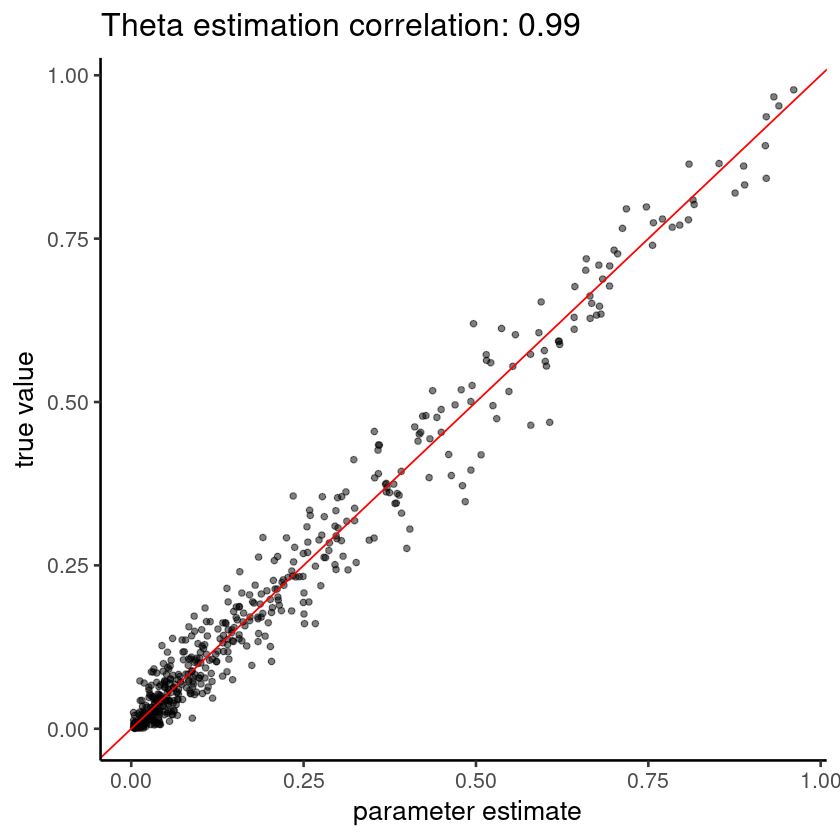

In [10]:
p1

## $\Gamma$ estimation

In [15]:
## compare the estimated Gammas to the real Gammas
library(tidyverse)
Gamma_pred = as_array(mod0$VIparam$Xi$cpu()$clone())
Gamma_true = as_array(truth_vals$Gamma$cpu()$clone())
pred_zeta = mod0$VIparam$zeta$cpu()$clone()
pred_gamma_sigma = as_array(mod0$
                            Bparam$gamma_sigma$cpu())
perm = as.numeric(matching)


In [16]:
## Match the Gammas to the previous matching with the thetas. 


if ( K %in% perm[1:(K-1)]){
    gamS = Gamma_pred[which(perm == (K)),]
    Gamma_pred = Gamma_pred - gamS
    Gamma_pred[which(perm == (K)),] = Gamma_pred[which(perm == (K)),,drop=FALSE] - gamS
    tmp = perm[which(perm == (K))]
    perm[which(perm == (K))] = perm[K]
    perm[K] = tmp
}


In [17]:
perm_index = perm[1:(K-1)]
plot_gamma_df = data.frame(gamma_est = matrix(Gamma_pred[perm[1:(K-1)],],ncol=1),
                          gamma_true = matrix(Gamma_true, ncol=1), 
                          gamma_sigs = matrix(apply(as_array(pred_zeta[perm_index]), 1, diag), nc=1),
                          gamma_sigs_ = matrix(rep(pred_gamma_sigma[perm[1:(K-1)]], p), nc=1))

In [18]:
head(plot_gamma_df)

,gamma_est,gamma_true,gamma_sigs,gamma_sigs_
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.07446811,0.1140050,0.01701862,0.3672130
2,-0.06719913,0.1488729,0.01705400,0.2976633
3,-0.47555465,-0.1861942,0.01914754,0.2756853
4,-0.45584771,-0.1831192,0.01814729,0.2600808
5,-0.29721418,-0.4761350,0.01541295,0.3672130
6,-0.35762438,-0.4912372,0.01718228,0.2976633


In [19]:
get_CI <- function(m,v, prcntile){
    tmp = rnorm(n=10000,mean = m, sd = v)
    return(quantile(tmp, prcntile))
}

plot_gamma_df = plot_gamma_df %>% rowwise() %>%  mutate(upper_CI = get_CI(gamma_est, sqrt(gamma_sigs), 0.975)) %>% 
    mutate(lower_CI = get_CI(gamma_est, sqrt(gamma_sigs), 0.125)) %>% ungroup()

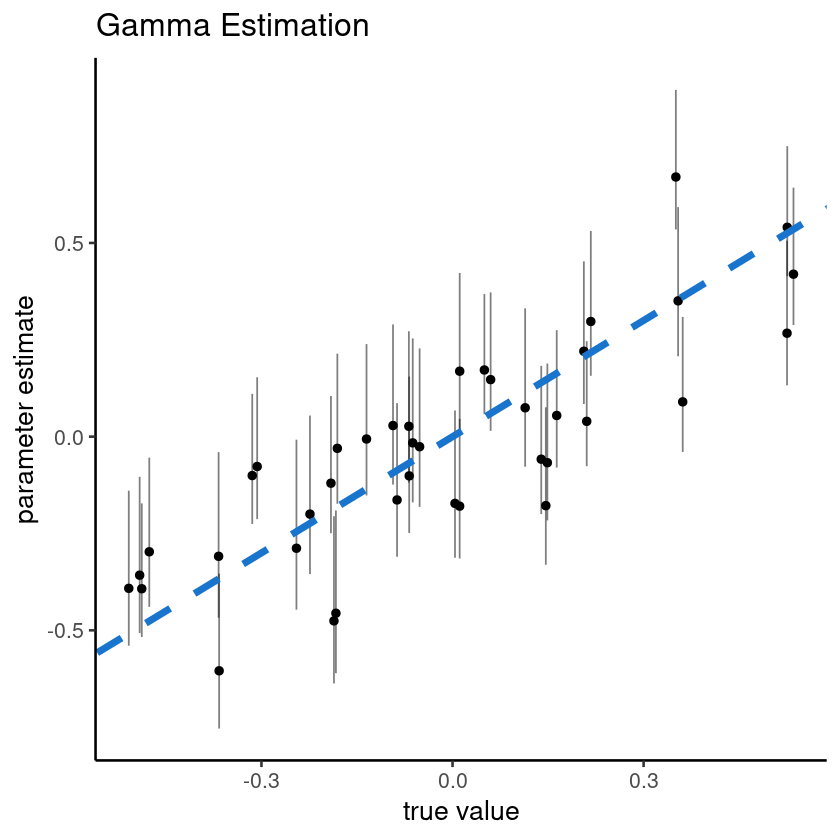

In [20]:
p2 = plot_gamma_df %>% ggplot(aes(y= gamma_est, x = gamma_true)) + geom_point(size=2) + 
    geom_linerange(aes(ymin = lower_CI, ymax = upper_CI), alpha=0.5) +
    geom_abline(slope=1,linetype="dashed", lwd=2, color = "dodgerblue3") + theme_classic(base_size = 16) + 
    labs(x="true value",y="parameter estimate", title="Gamma Estimation")
p2

## T, factors esimations

In [22]:
plotting_factors <- function(sim,true, title){
    corr_sim = round(cor(sim,true),2)
    plot_df = data.frame(x=sim,y=true)
    plot_df %>% ggplot(aes(x=x,y=y)) + geom_point(alpha=0.5) + geom_abline(slope = 1,color="red") +
    theme_classic(base_size = 16) + labs(x=" parameter estimate",y="true value",
                                         title=paste(title,"correlation:",corr_sim))
}

In [23]:
perm_index = perm[1:K]
T0_sim = as_array(mod0$Bparam$T0[..,perm_index]$clone()$flatten()$cpu())
T0_true = as_array(truth_vals$T0$clone()$flatten()$cpu())

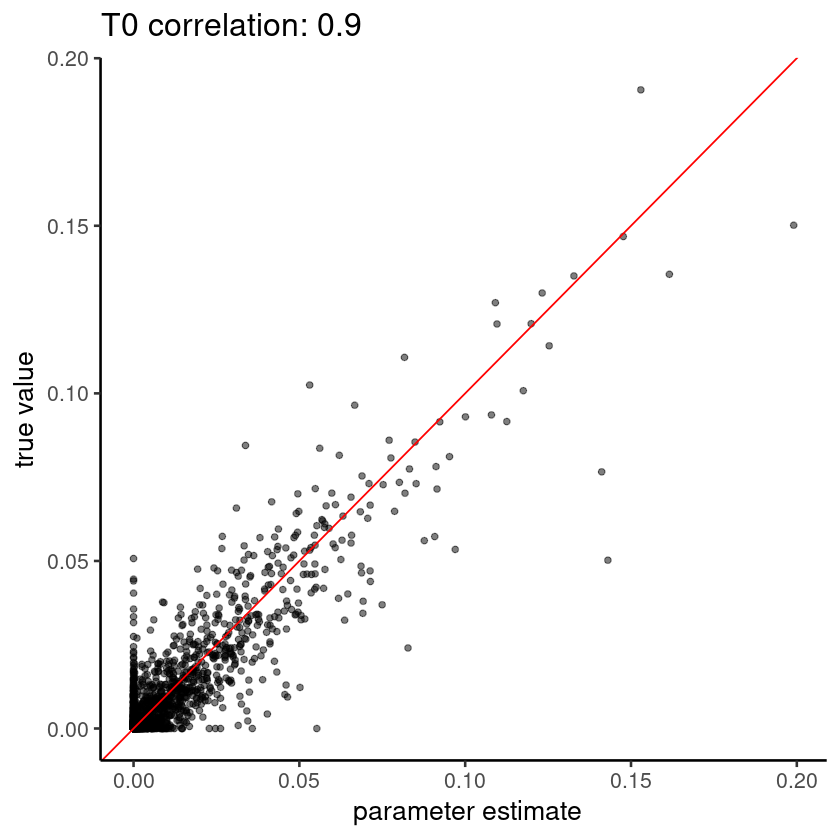

In [24]:
p3 = plotting_factors(T0_sim,T0_true,"T0")
p3

In [25]:
## factors
perm_index = as.numeric(matching)
factors_sim = c(
                as_array(mod0$Bparam$factors$bt$clone()$cpu()[1:2,as.integer(matching)]$flatten()),
                as_array(mod0$Bparam$factors$br$clone()$cpu()[1:2,as.integer(matching)]$flatten()),
                as_array(mod0$Bparam$factors$epi$clone()$cpu()[,as.integer(matching)]$flatten()),
                as_array(mod0$Bparam$factors$nuc$clone()$cpu()[,as.integer(matching)]$flatten()),
                as_array(mod0$Bparam$factors$clu$clone()$cpu()[,as.integer(matching)]$flatten())
              )

factors_true = c(
                as_array(truth_vals$factors$bt$clone()$cpu()$flatten()),
                as_array(truth_vals$factors$br$clone()$cpu()$flatten()),
                as_array(truth_vals$factors$epi$clone()$cpu()$flatten()),
                as_array(truth_vals$factors$nuc$clone()$cpu()$flatten()),
                as_array(truth_vals$factors$clu$clone()$cpu()$flatten())
              )

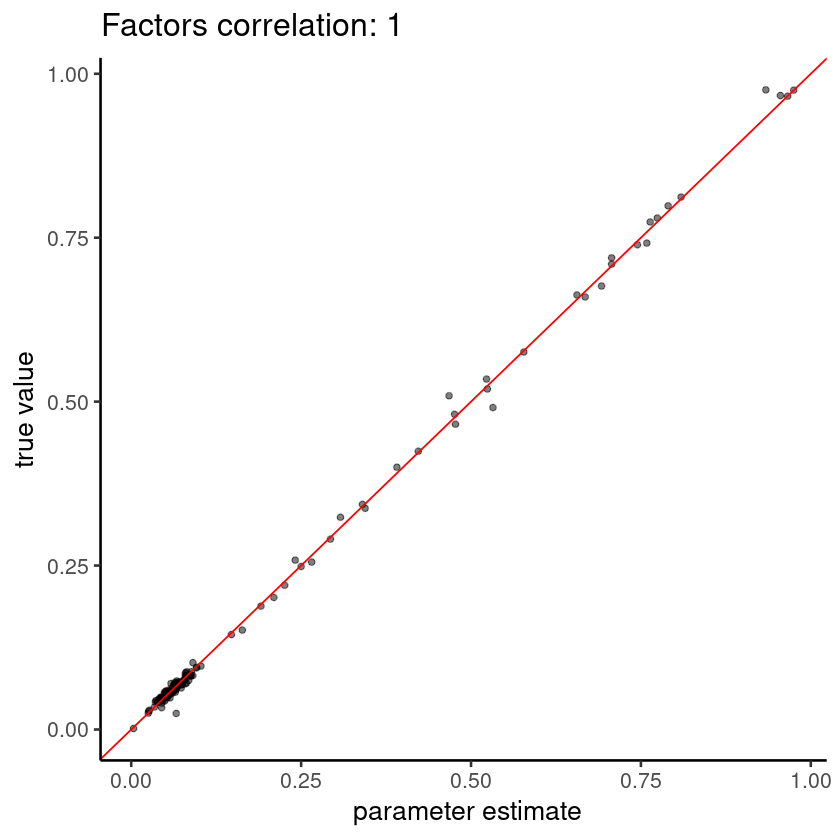

In [26]:
p4 = plotting_factors(factors_sim,factors_true,"Factors")
p4

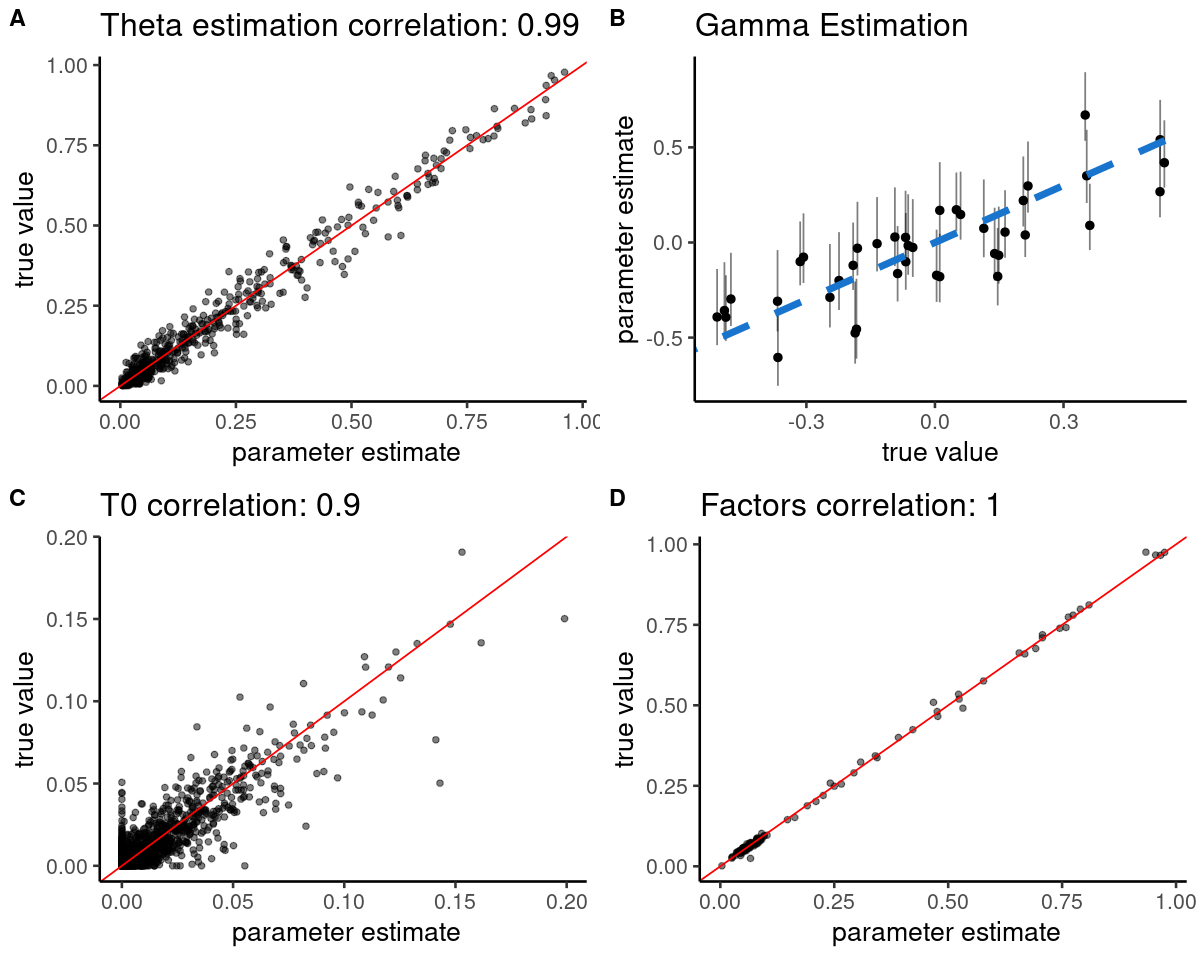

In [27]:

library(ggpubr)
options(repr.plot.width=10, repr.plot.height=8)
px = ggarrange(p1,p2,p3,p4,ncol =2,nrow = 2,labels = c("A","B","C","D"))
px

ggsave(px, filename="../figures/estimation_simulation.pdf", device="pdf",height=8, width=10)